In [ ]:
# pip install odc-stac
# pip install dask==2025.2.0 (2025.3.0 -> esta dando erro)
# pip install distributed==2025.2.0
# pip install dask[distributed]

In [1]:
import os
import json
import yaml
import logging
import pystac
import folium
import folium.plugins
import dask
import dask.distributed
import pandas as pd
import geopandas as gpd
import shapely.geometry

from IPython.display import HTML, display
from copy import deepcopy
from odc.stac import stac_load
from odc.stac import configure_rio, stac_load
from shapely.geometry import shape
from pystac_client import Client
from pystac.extensions.projection import ProjectionExtension
from pyproj import CRS

In [2]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [3]:
client = dask.distributed.Client()

configure_rio(cloud_defaults=True, aws={"aws_unsigned": True}, client=client)
display(client)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 15.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39855,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.35 GiB
Comm: tcp://127.0.0.1:45881,Total threads: 4
Dashboard: http://127.0.0.1:41441/status,Memory: 3.84 GiB
Nanny: tcp://127.0.0.1:39735,


In [4]:
km2deg = 1.0 / 111
x, y   = (113.887, -25.843)  # Center point of a query
r      = 100 * km2deg
bbox   = (x - r, y - r, x + r, y + r)

In [5]:
catalog = Client.open("https://earth-search.aws.element84.com/v1/")

In [6]:
query = catalog.search(
    collections=["sentinel-2-l2a"],
	datetime="2021-09-16",
	limit=100,
	bbox=bbox
)

items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 18 datasets


In [7]:
# Convert STAC items into a GeoJSON FeatureCollection
stac_json = query.item_collection_as_dict()

### Review Query Result

In [8]:
gdf = gpd.GeoDataFrame.from_features(stac_json, "epsg:4326")

# Compute granule id from components
gdf["granule"] = (
    gdf["mgrs:utm_zone"].apply(lambda x: f"{x:02d}")
    + gdf["mgrs:latitude_band"]
    + gdf["mgrs:grid_square"]
)

In [11]:
print(gdf.shape)

(18, 43)


In [10]:
gdf.head(3)

,geometry,created,platform,constellation,instruments,eo:cloud_cover,proj:epsg,mgrs:utm_zone,mgrs:latitude_band,mgrs:grid_square,...,s2:granule_id,s2:reflectance_conversion_factor,datetime,s2:sequence,earthsearch:s3_path,earthsearch:payload_id,earthsearch:boa_offset_applied,processing:software,updated,granule
0,"POLYGON ((113.00474 -26.20542, 112.73274 -27.2...",2023-07-11T20:28:26.669Z,sentinel-2a,sentinel-2,[msi],38.721323,32749,49,J,FL,...,S2A_OPER_MSI_L2A_TL_S2RP_20230122T070659_A0325...,0.987871,2021-09-16T02:35:21.194000Z,1,s3://sentinel-cogs/sentinel-s2-l2a-cogs/49/J/F...,roda-sentinel2/workflow-sentinel2-to-stac/f3d5...,True,{'sentinel2-to-stac': '0.1.1'},2023-07-11T20:28:26.669Z,49JFL
1,"POLYGON ((113.00313 -26.20544, 113.09971 -26.2...",2022-11-06T08:34:15.193Z,sentinel-2a,sentinel-2,[msi],35.644225,32749,49,J,FL,...,S2A_OPER_MSI_L2A_TL_VGS1_20210916T064116_A0325...,0.987871,2021-09-16T02:35:21.194000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/49/J/F...,roda-sentinel2/workflow-sentinel2-to-stac/284e...,False,{'sentinel2-to-stac': '0.1.0'},2022-11-06T08:34:15.193Z,49JFL
2,"POLYGON ((113.0031 -26.20544, 114.09915 -26.18...",2022-11-06T05:19:34.633Z,sentinel-2a,sentinel-2,[msi],23.280485,32749,49,J,GL,...,S2A_OPER_MSI_L2A_TL_VGS1_20210916T064116_A0325...,0.987871,2021-09-16T02:35:16.888000Z,0,s3://sentinel-cogs/sentinel-s2-l2a-cogs/49/J/G...,roda-sentinel2/workflow-sentinel2-to-stac/da35...,False,{'sentinel2-to-stac': '0.1.0'},2022-11-06T05:19:34.633Z,49JGL


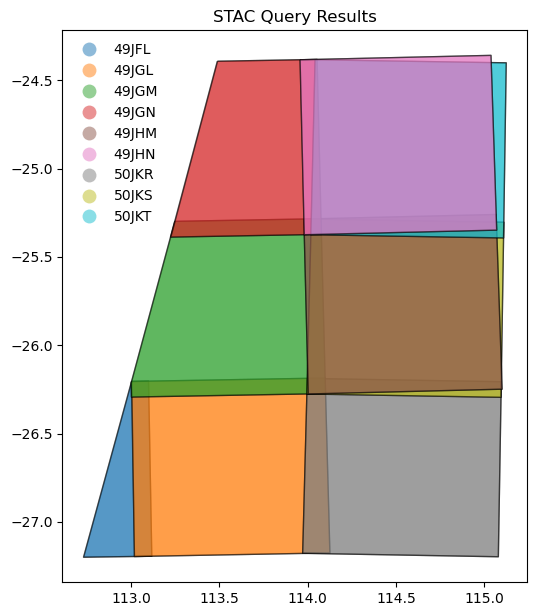

In [12]:
fig = gdf.plot(
    "granule",
    edgecolor="black",
    categorical=True,
    aspect="equal",
    alpha=0.5,
    figsize=(6, 12),
    legend=True,
    legend_kwds={"loc": "upper left", "frameon": False, "ncol": 1},
)

_ = fig.set_title("STAC Query Results")

### Plot STAC Items on a Map

In [14]:
from branca.element import Figure

In [15]:
fig = Figure(width="400px", height="500px")
map1 = folium.Map()
fig.add_child(map1)

folium.GeoJson(
    shapely.geometry.box(*bbox),
    style_function=lambda x: dict(fill=False, weight=1, opacity=0.7, color="olive"),
    name="Query",
).add_to(map1)

gdf.explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "datetime",
        "eo:cloud_cover",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="STAC",
    m=map1,
)

map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))
display(fig)

/tmp/ipykernel_250748/3456774104.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  map1.fit_bounds(bounds=convert_bounds(gdf.unary_union.bounds))


### Construct Dask Dataset

In [16]:
# Since we will plot it on a map we need to use `EPSG:3857` projection
crs  = "epsg:3857"
zoom = 2**5  # overview level 5

xx = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10 * zoom,
    chunks={},  # <-- use Dask
    groupby="solar_day",
)
display(xx)

<xarray.Dataset> Size: 7MB
Dimensions:      (y: 1101, x: 1087, time: 1)
Coordinates:
  * y            (y) float64 9kB -2.797e+06 -2.798e+06 ... -3.149e+06 -3.149e+06
  * x            (x) float64 9kB 1.247e+07 1.247e+07 ... 1.282e+07 1.282e+07
    spatial_ref  int32 4B 3857
  * time         (time) datetime64[ns] 8B 2021-09-16T02:34:44.451000
Data variables:
    red          (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    green        (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>
    blue         (time, y, x) uint16 2MB dask.array<chunksize=(1, 1101, 1087), meta=np.ndarray>

In [19]:
type(xx)

xarray.core.dataset.Dataset

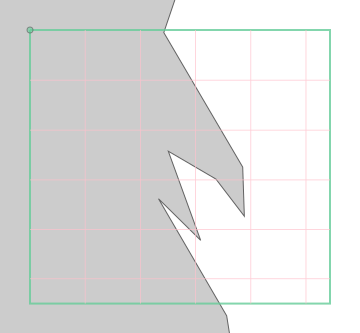

In [17]:
xx.odc.geobox

### Load data into local memory

In [20]:
%%time
xx = xx.compute()

CPU times: user 791 ms, sys: 155 ms, total: 946 ms
Wall time: 20.4 s


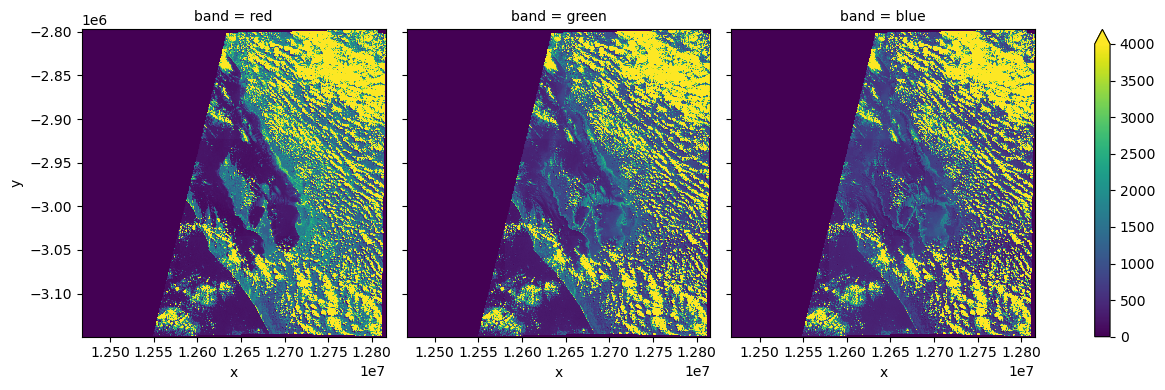

In [21]:
_ = (
    xx.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)

### Load with bounding box

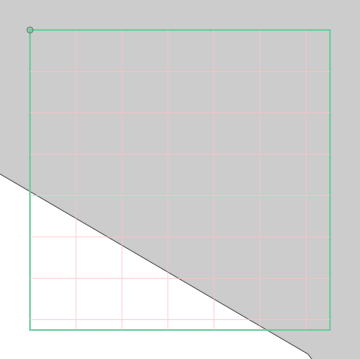

In [22]:
r          = 6.5 * km2deg
small_bbox = (x - r, y - r, x + r, y + r)

yy = stac_load(
    items,
    bands=("red", "green", "blue"),
    crs=crs,
    resolution=10,
    chunks={},  # <-- use Dask
    groupby="solar_day",
    bbox=small_bbox,
)
display(yy.odc.geobox)

In [23]:
yy = yy.compute()

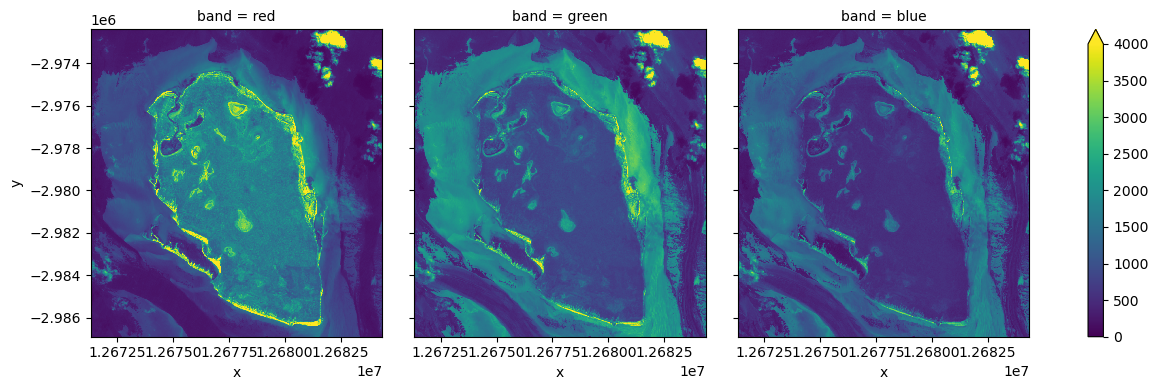

In [24]:
_ = (
    yy.isel(time=0)
    .to_array("band")
    .plot.imshow(
        col="band",
        size=4,
        vmin=0,
        vmax=4000,
    )
)